In [1]:
# To not mess up fastai container we need a special one
# for raster and shape manipulation
# docker pull jupyter/datascience-notebook
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.geometry import box
import matplotlib.pyplot as plt
import os
import numpy as np
from itertools import product
import zipfile

# RASTERIO is not part of docker container
# to install package jump into running container with
# docker exec -ti
# conda install -c conda-forge rasterio
import rasterio as rio
from rasterio import windows
from rasterio import features
from rasterio.plot import show
from rasterio.mask import mask

In [2]:
from PIL import Image
import numpy as np

im_frame = Image.open("0016E5_08550_P.png")
np_frame = np.array(im_frame.getdata())
np.unique(np_frame)

array([ 1,  4,  5,  6,  8,  9, 10, 12, 14, 16, 17, 19, 21, 26, 27, 30, 31])

In [3]:
im_frame2 = Image.open("ruian_tiles/tile_2196-1647.tif")
np_frame2 = np.array(im_frame2.getdata())
np.unique(np_frame2)

array([ 2,  5,  6,  7, 10, 11, 13, 14])

- - -
### Exaple of Image and GroundTruth from GitHub
Image - 3band RGB .png
GroundTruth - 1band .png

In [2]:
!gdalinfo 0016E5_08550_P.png

Driver: PNG/Portable Network Graphics
Files: 0016E5_08550_P.png
Size is 960, 720
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0,  720.0)
Upper Right (  960.0,    0.0)
Lower Right (  960.0,  720.0)
Center      (  480.0,  360.0)
Band 1 Block=960x1 Type=Byte, ColorInterp=Gray


In [8]:
!gdalinfo "/home/jovyan/work/CNN_Land_Use/ruian_tiles/tile_2196-1647.tif"

Driver: GTiff/GeoTIFF
Files: /home/jovyan/work/CNN_Land_Use/ruian_tiles/tile_2196-1647.tif
Size is 549, 549
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 33N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 33N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",15,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1]

In [7]:
!pwd

/home/jovyan/work/CNN_Land_Use


In [ ]:
# GITHUB EXAMPLE

# https://github.com/YudeWang/UNet-Satellite-Image-Segmentation

In [31]:
corrner_coords

['509760.000, 5390220.000']

In [2]:
# raster information for 1band image with yone classes
!gdalinfo "./examples/2_class.png"

Driver: PNG/Portable Network Graphics
Files: ./examples/2_class.png
Size is 7969, 7939
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0, 7939.0)
Upper Right ( 7969.0,    0.0)
Lower Right ( 7969.0, 7939.0)
Center      ( 3984.5, 3969.5)
Band 1 Block=7969x1 Type=Byte, ColorInterp=Gray
  NoData Value=255


/opt/conda/lib/python3.8/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


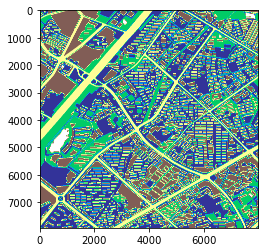

<AxesSubplot:>

In [6]:
clas_img = rio.open("./examples/2_class.png")
show((clas_img, 1), cmap='terrain')

In [3]:
# raster information for 3band RGB image with yone classes
!gdalinfo "./examples/2.png"

Driver: PNG/Portable Network Graphics
Files: ./examples/2.png
Size is 7969, 7939
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0, 7939.0)
Upper Right ( 7969.0,    0.0)
Lower Right ( 7969.0, 7939.0)
Center      ( 3984.5, 3969.5)
Band 1 Block=7969x1 Type=Byte, ColorInterp=Red
Band 2 Block=7969x1 Type=Byte, ColorInterp=Green
Band 3 Block=7969x1 Type=Byte, ColorInterp=Blue


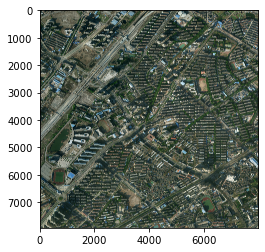

In [7]:
# plotting RGB image with rasterio
with rio.open("./examples/2.png") as src:
    arr = src.read([1, 2, 3], masked=True)
    show(arr)

end of reference example
- - -

## Processing Sentinel2 image pack

In [47]:
# 1. WE START AT POINT THAT WE HAVE SENTINEL IMAGE PACK DOWLOADED
# S2B_MSIL2A_20200821T100559_N0214_R022_T33UVQ_20200821T130423

# FROM REAL "Sentinel image pack" EXTRACT 3band TCI(true color image - RGB)
# Structure of Sentinel Image pack
# 10m:
#     T33UVQ_20200821T100559_B03_10m.jp2
#     T33UVQ_20200821T100559_B02_10m.jp2
#     T33UVQ_20200821T100559_AOT_10m.jp2 -aerosol
#     T33UVQ_20200821T100559_B08_10m.jp2
#     T33UVQ_20200821T100559_B04_10m.jp2
#     T33UVQ_20200821T100559_TCI_10m.jp2 -true ground image
#     T33UVQ_20200821T100559_WVP_10m.jp2 - water vapour

# Unziping without tree structure
file = "S2B_MSIL2A_20200821T100559_N0214_R022_T33UVQ_20200821T130423"
with zipfile.ZipFile(f'{file}.zip') as zipp:
    for zip_info in zipp.infolist():
        if zip_info.filename.endswith('TCI_10m.jp2'):# or zip_info.filename.endswith('B08_10m.jp2'):
            zip_info.filename = os.path.basename(zip_info.filename)
            zipp.extract(zip_info)


In [5]:
# get metadata info for corner coordinates of picture
# we can use GDALINFO and hard-code it or use XML parser to get appropriate info

# GDAL
info = !gdalinfo T33UVQ_20200821T100559_TCI_10m.jp2
info

['Driver: JP2OpenJPEG/JPEG-2000 driver based on OpenJPEG library',
 'Files: T33UVQ_20200821T100559_TCI_10m.jp2',
 'Size is 10980, 10980',
 'Coordinate System is:',
 'PROJCRS["WGS 84 / UTM zone 33N",',
 '    BASEGEOGCRS["WGS 84",',
 '        DATUM["World Geodetic System 1984",',
 '            ELLIPSOID["WGS 84",6378137,298.257223563,',
 '                LENGTHUNIT["metre",1]]],',
 '        PRIMEM["Greenwich",0,',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '        ID["EPSG",4326]],',
 '    CONVERSION["UTM zone 33N",',
 '        METHOD["Transverse Mercator",',
 '            ID["EPSG",9807]],',
 '        PARAMETER["Latitude of natural origin",0,',
 '            ANGLEUNIT["degree",0.0174532925199433],',
 '            ID["EPSG",8801]],',
 '        PARAMETER["Longitude of natural origin",15,',
 '            ANGLEUNIT["degree",0.0174532925199433],',
 '            ID["EPSG",8802]],',
 '        PARAMETER["Scale factor at natural origin",0.9996,',
 '            SCALEUNIT["unity",1

In [6]:
# extract EPSG number from GDAILINFO
epsg_idx = [(info.index(l)-1) for l in info if l.startswith('Data axis to CRS')]
epsg_num = info[epsg_idx[0]].split(',')[1].rstrip(']')
epsg = f'EPSG:{epsg_num}'
epsg

'EPSG:32633'

In [7]:
# create corner coordinate from GDALINFO for shapely and geopandas

# start index number in infolist for coords corners
coord_idx = [info.index(l) for l in info if l.startswith('Upper Left')]
start, stop = coord_idx[0], coord_idx[0]+4
coords = []
order = [0, 2, 3, 1]

for i in info[start:stop]:
    xy = i[15:38]
#     print(i)
#     print(xy)
    cx = float(xy.split(',')[0])
    cy = float(xy.split(',')[1])
    xy_tup =(cx, cy)
    coords.append(xy_tup)

# reorder coords to further polygon creation
coords[:] = [coords[i] for i in order]

In [8]:
# Bounding box of Sentinel2 Image

# shapely-like object
s2_poly = Polygon(coords)

# geopandas dataframe from shapely-like objet
s2imageBox = gpd.GeoDataFrame({'geometry':[s2_poly]},crs=epsg)
s2imageBox

,geometry
0,"POLYGON ((399960.000 5500020.000, 509760.000 5..."


In [17]:
10980/45

244.0

In [18]:
# GRID-FOR-SENTINEL-IMAGE

# Cretate rectangular grids for Sentinel image, they are allways 10980*10980 px
# so we get 20*20 rectangles with 549*549 px
# for memory efficienti of FASTAI better use 183x183 px

xmin,ymin,xmax,ymax = s2_poly.bounds
length = 2440
wide = 2440

cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), wide))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), length))
rows.reverse()

polygons = []
for x in cols:
    for y in rows:
#         polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]) )
        polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]) )

s2imageBox_grid = gpd.GeoDataFrame({'geometry':polygons}, crs="EPSG:32633")
s2imageBox_grid

,geometry
0,"POLYGON ((399960.000 5497580.000, 402400.000 5..."
1,"POLYGON ((399960.000 5495140.000, 402400.000 5..."
2,"POLYGON ((399960.000 5492700.000, 402400.000 5..."
3,"POLYGON ((399960.000 5490260.000, 402400.000 5..."
4,"POLYGON ((399960.000 5487820.000, 402400.000 5..."
...,...
2020,"POLYGON ((507320.000 5399980.000, 509760.000 5..."
2021,"POLYGON ((507320.000 5397540.000, 509760.000 5..."
2022,"POLYGON ((507320.000 5395100.000, 509760.000 5..."
2023,"POLYGON ((507320.000 5392660.000, 509760.000 5..."


## RUIAN vectors to polygons

In [19]:
# loading vector data with RUIAN geometries in categories:

# 2,orná půda
# 3,chmelnice
# 4,vinice
# 5,zahrada
# 6,ovocný sad
# 7,trvalý travní porost
# 8,trvalý travní porost
# 10,lesní pozemek
# 11,vodní plocha
# 13,zastavěná plocha a nádvoří
# 14,ostatní plocha
# array([ 2,  5,  6,  7, 10, 11, 13, 14])

ruian = os.path.join(os.getcwd(), 'shp', 'RUIAN_ORP_CB.shp')

df = gpd.read_file(ruian)
df = df.loc[df['geometry'].is_valid, :] # get rid of invalid geomtries

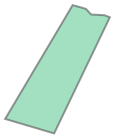

In [20]:
Polygon(df.geometry[706]) # show one polygon from geopandas-dataframe using shapely

In [21]:
# aggregating by attribute
df_poz = df[['DRUPOZKOD', 'geometry']]
df_katg = df_poz.dissolve(by='DRUPOZKOD')
# asign coordinate system
df_katg.crs = "EPSG:5514"

In [22]:
del df # we can df now delete cause we got categorized df_katg

In [23]:
# REPROJECTING - it will take a time to recalculate all geometries
df_katg_rpjct = df_katg.to_crs("EPSG:32633") # reproject RUIAN to (rasters) Sentinel2 default crs EPSG:32633

In [24]:
del df_katg # we no longer need df_katg with CRS-"EPSG:5514"

In [25]:
# BOUNDING BOX OF VECTOR DATA

# Polygon from bounding box of kategorized dataframe 'df_katg_rpjct'
# we use geopandas '.total_bounds' and shapely 'box'
df_ktg_bbox = gpd.GeoDataFrame({'geometry':[box(*df_katg_rpjct.total_bounds)]},crs="EPSG:32633")

In [10]:
# SPATIAL INTERSETCTION - the right way to do intersection, like in GIS

# https://gis.stackexchange.com/questions/375407/geopandas-intersects-doesnt-find-any-intersection
'''
import nunpy as np
inp, res = regions.sindex.query_bulk(points.geometry, predicate='intersects')
points['intersects'] = np.isin(np.arange(0, len(points)), inp)
'''

"\nimport nunpy as np\ninp, res = regions.sindex.query_bulk(points.geometry, predicate='intersects')\npoints['intersects'] = np.isin(np.arange(0, len(points)), inp)\n"

<AxesSubplot:>

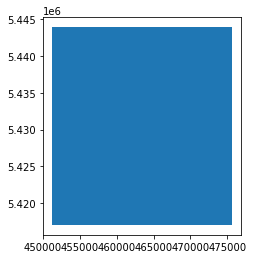

In [35]:
# BOUNDING BOX IN SENTINEL RASTER GRID THAT CONTAINS ALL VECTOR DATA

# constructing bbox of all satellite images that cover our vector layer
# manualy sing plot below and picking two patches
xmin,ymin,xmax,ymax = s2imageBox_grid.loc[968].geometry.bounds
xmin2,ymin2,xmax2,ymax2 = s2imageBox_grid.loc[1383].geometry.bounds

sat_bbox = (xmin,ymax,xmax2,ymin2)

aoi_sat_bbox = gpd.GeoDataFrame({'geometry':[box(*sat_bbox)]},crs="EPSG:32633")
aoi_sat_bbox.plot()

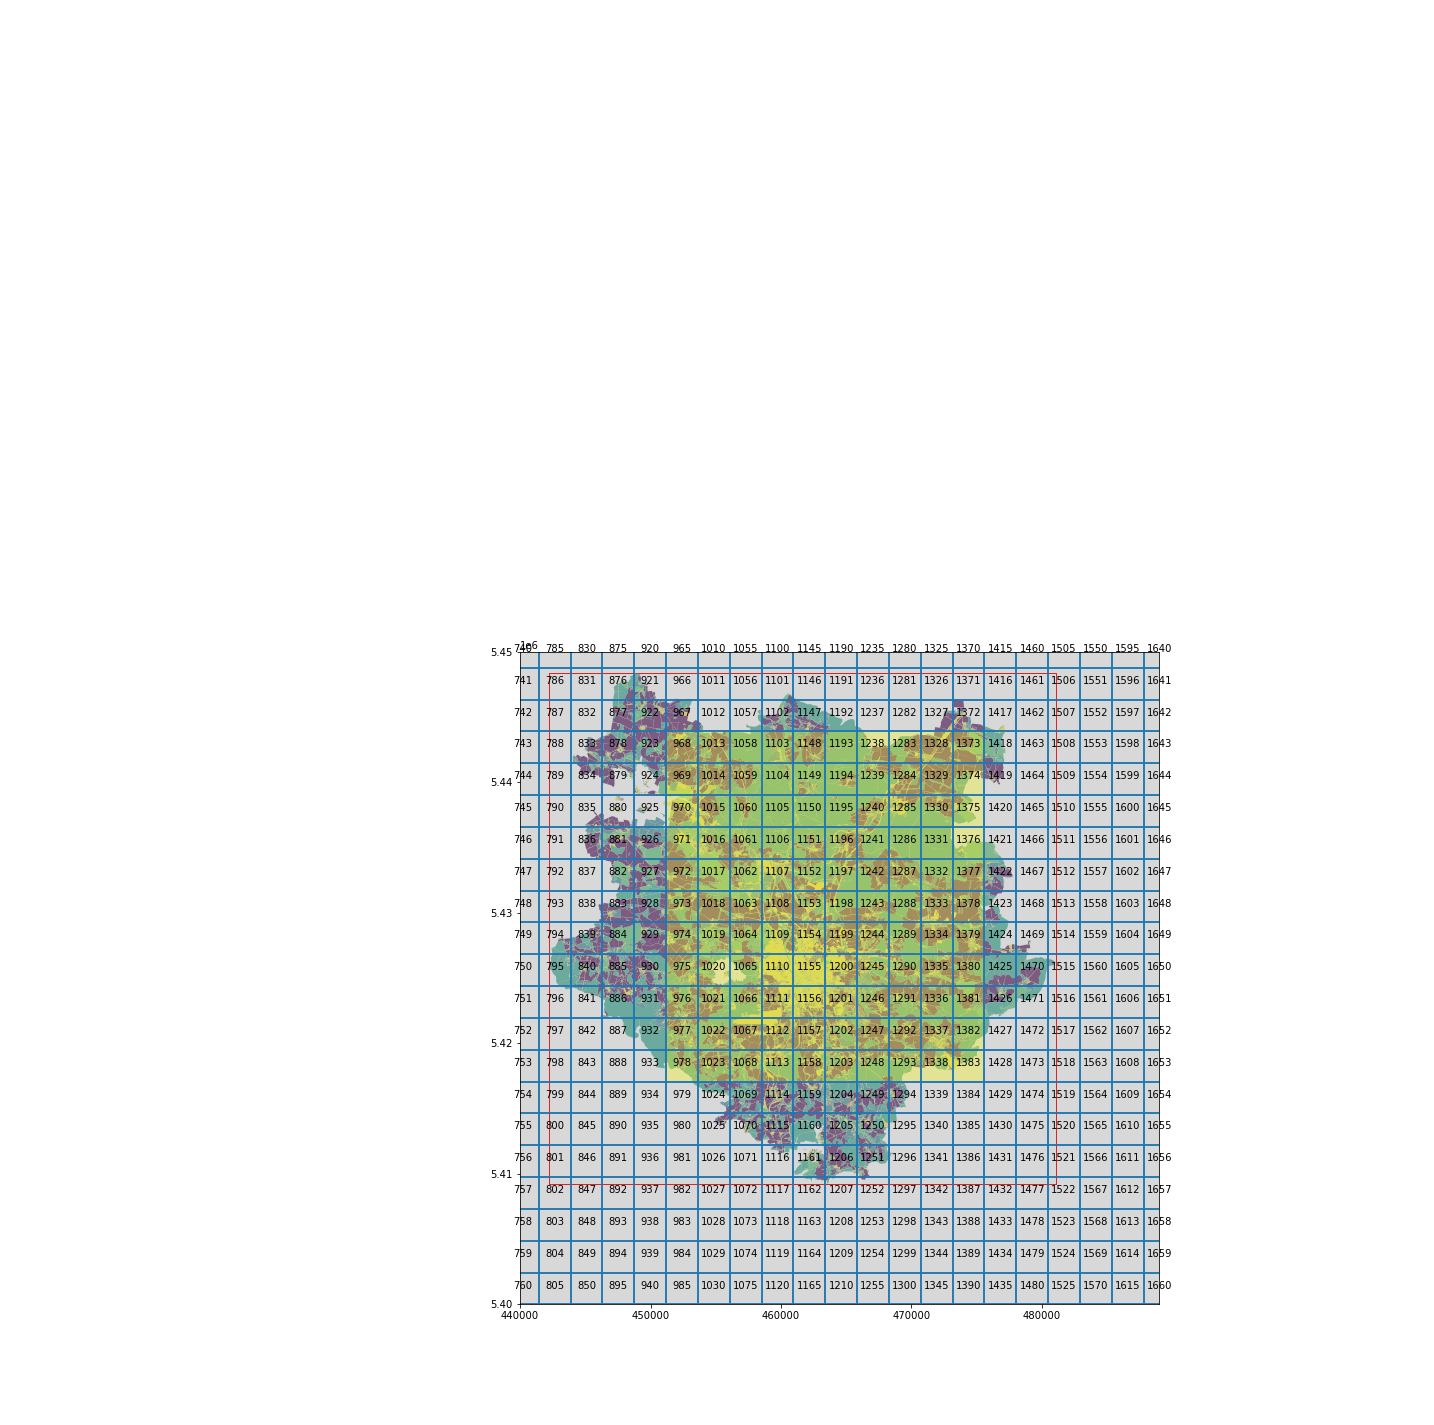

In [36]:
# PLOT

# plotting all in EPSG 32633 - native crs of sentinel2 images
fig, ax = plt.subplots (figsize = (12,12))

df_ktg_bbox.plot(ax = ax, facecolor="none", edgecolor='red') #reproj. kateg. poly. RUIAN Bbox
df_katg_rpjct.plot(ax = ax, alpha = 0.7, cmap='viridis') #reproj. kateg. poly. RUIAN

s2imageBox.plot(ax = ax, alpha = 0.3, color = "grey")
s2imageBox_grid.boundary.plot(ax = ax)
aoi_sat_bbox.plot(ax = ax, color='yellow', alpha = 0.3)


ax.set_xlim(440_000, 489_000)
ax.set_ylim(5_400_000, 5_450_000)

# plt.axis([x_min, x_max, y_min, y_max])
plt.axis([440_000, 489_000, 5_400_000, 5_450_000])

# number labels for each patch based on .loc in geodataframe
for i, geo in s2imageBox_grid.boundary.centroid.iteritems():
    ax.annotate(text=i, xy=[geo.x, geo.y], color="black", horizontalalignment='center')
    

# fig= plt.gcf()

plt.show()

In [55]:
# Now we should rasterize vector polygons to create raster with size of yellow area
# https://towardsdatascience.com/use-python-to-convert-polygons-to-raster-with-gdal-rasterizelayer-b0de1ec3267

# each patch has 549*549 px
# yellow area is 8*8 patches = 4392*4392 px


In [37]:
# GDAL VECTOR AND RASTER PROCESSING

# Crop input BIG raster to AOI "yellow area"

# will be used as TEMPLATE for vector rasterization

# in_satImg = 'T33UVQ_20200821T100559_B04_10m.jp2'
in_satImg = 'T33UVQ_20200821T100559_TCI_10m.jp2'

# future cropped raster
out_aoiSatImg = f'crop_{in_satImg}'

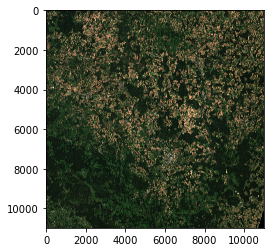

<AxesSubplot:>

In [38]:
bigIMG = rio.open(in_satImg)

show(bigIMG.read([1, 2, 3], masked=True))

In [39]:
# From above we have YELLOW AREA as gpd.GeoDataframe named: aoi_sat_bbox

# we need to get the coordinates of the geometry(aoi_sat_bbox) in such a format
# that rasterio wants them. This can be conducted easily with following function

# or it accept shapely like geometry

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [40]:
# Coords for RASTERIO to crop raster aka YELLOW AREA
coords = getFeatures(aoi_sat_bbox)
coords

[{'type': 'Polygon',
  'coordinates': [[[475600.0, 5443900.0],
    [475600.0, 5417060.0],
    [451200.0, 5417060.0],
    [451200.0, 5443900.0],
    [475600.0, 5443900.0]]]}]

In [41]:
out_img, out_transform = mask(dataset=bigIMG, shapes=coords, crop=True, nodata=0)

In [42]:
out_meta = bigIMG.meta.copy()
out_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32633),
 'transform': Affine(10.0, 0.0, 399960.0,
        0.0, -10.0, 5500020.0)}

In [43]:
out_meta.update({"driver": "GTiff",
                  "height": out_img.shape[1],
                  "width": out_img.shape[2],
                  "transform": out_transform,
                  }
                )

In [44]:
# writing new cropped image of YELLOW AREA
with rio.open(out_aoiSatImg, "w", **out_meta) as dest:
    dest.write(out_img)

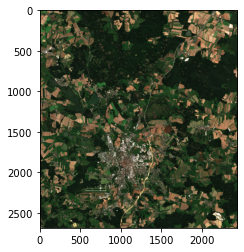

<AxesSubplot:>

In [45]:
clipped = rio.open(out_aoiSatImg)

show(clipped.read([1, 2, 3], masked=True))

In [46]:
# RASTRIZE VECTOR RUIAN

# Input geometries: 'df_katg_rpjct'
#     it is aggregated by DRUHPOZEMKU and reprojected
#     to CRS of Sentinel IMAGE

# Input raster template: out_aoiSatImg saved in variable "clipped"
#     is above created cropped raster aka YELLOW AREA size

# Output file path for new RASTER created from VECTOR polygons
out_rasRized = './crop_RasterizedRUIAN.tif'

In [47]:
clipped.meta.update(compress='lzw')

In [48]:
df_katg_rpjct.index

Int64Index([2, 5, 6, 7, 10, 11, 13, 14], dtype='int64', name='DRUPOZKOD')

In [49]:
with rio.open(out_rasRized, 'w+', **clipped.meta) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(df_katg_rpjct.geometry, df_katg_rpjct.index))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

In [95]:
!ls

aoiSentinelImg.tif
crop_RasterizedRUIAN.tif
crop_T33UVQ_20200821T100559_TCI_10m.jp2.tif
EuroSAT
EuroSATallBands.zip
EuroSAT.zip
examples
Forest_1.jpg
LandUseFastaiPytorch.ipynb
rasInfo.txt
roadmap.txt
ruian_tiles
ruian_to_gdf.ipynb
S2B_MSIL2A_20200821T100559_N0214_R022_T33UVQ_20200821T130423.zip
sentinel_download.ipynb
shp
T33UVQ_20200821T100559_B04_10m.jp2
T33UVQ_20200821T100559_TCI_10m.jp2


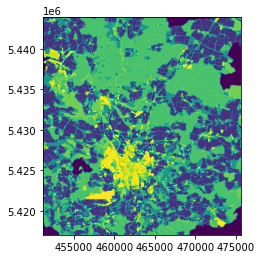

<AxesSubplot:>

In [50]:
rasRUIAN  = rio.open(out_rasRized)
show((rasRUIAN, 1), cmap='viridis')

In [57]:
len(yy)

11

In [68]:
# CREATE TILES FROM RASTERIZED VECTOR

# define tile W-width and H-height
W = 244
H = 244



def get_tiles(ds, width=W, height=H):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

# './ruian_tiles/''sentinel_tiles'     
        
def get_filename():
    cols = [col for col in range(10)]
    rows = [row for row in 'ABCDEFGHIJK']
    for col in cols:
        for row in rows:
            yield f'./sentinel_tiles/tile_{col}-{row}.tif'




In [69]:
# 'crop_T33UVQ_20200821T100559_TCI_10m.jp2.tif', './crop_RasterizedRUIAN.tif'

with rio.open('./crop_T33UVQ_20200821T100559_TCI_10m.jp2.tif') as inds:
    tile_width, tile_height = W, H

    meta = inds.meta.copy()
    
    get_fn = get_filename()
    for window, transform in get_tiles(inds):
#         print(window.col_off, next(get_fn))
        meta['transform'] = transform
        meta['width'], meta['height'] = window.width, window.height
#         outpath = os.path.join(out_path,output_filename.format(int(window.col_off), int(window.row_off)))
        outpath = next(get_fn)
        with rio.open(outpath, 'w', **meta) as outds:
            outds.write(inds.read(window=window))

StopIteration: 

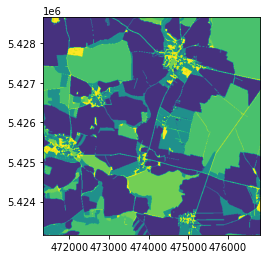

In [103]:
with rio.open('./ruian_tiles/tile_3294-2196.tif') as src:
    show((src, 1), cmap='viridis')

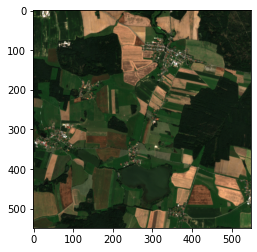

In [122]:
with rio.open('./sentinel_tiles/tile_3294-2196.tif') as src:
    arr = src.read([1, 2, 3], masked=True)
    show(arr)

In [121]:
# CREATE TILES FROM CROPPED Sentinle IMAGETOR

# define tile W-width and H-height
W = 549
H = 549

def get_tiles(ds, width=W, height=H):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform


with rio.open('crop_T33UVQ_20200821T100559_TCI_10m.jp2.tif') as inds:
    tile_width, tile_height = W, H

    meta = inds.meta.copy()

    for window, transform in get_tiles(inds):
        print(window)
        meta['transform'] = transform
        meta['width'], meta['height'] = window.width, window.height
#         outpath = os.path.join(out_path,output_filename.format(int(window.col_off), int(window.row_off)))
        outpath = f'./sentinel_tiles/tile_{window.col_off}-{window.row_off}.tif'
        with rio.open(outpath, 'w', **meta) as outds:
            outds.write(inds.read(window=window))

Window(col_off=0, row_off=0, width=549, height=549)
Window(col_off=0, row_off=549, width=549, height=549)
Window(col_off=0, row_off=1098, width=549, height=549)
Window(col_off=0, row_off=1647, width=549, height=549)
Window(col_off=0, row_off=2196, width=549, height=549)
Window(col_off=0, row_off=2745, width=549, height=549)
Window(col_off=0, row_off=3294, width=549, height=549)
Window(col_off=0, row_off=3843, width=549, height=549)
Window(col_off=549, row_off=0, width=549, height=549)
Window(col_off=549, row_off=549, width=549, height=549)
Window(col_off=549, row_off=1098, width=549, height=549)
Window(col_off=549, row_off=1647, width=549, height=549)
Window(col_off=549, row_off=2196, width=549, height=549)
Window(col_off=549, row_off=2745, width=549, height=549)
Window(col_off=549, row_off=3294, width=549, height=549)
Window(col_off=549, row_off=3843, width=549, height=549)
Window(col_off=1098, row_off=0, width=549, height=549)
Window(col_off=1098, row_off=549, width=549, height=549)


In [3]:
!ls ./sentinel_tiles/

tile_0-0.tif	    tile_1647-0.tif	tile_2745-0.tif     tile_3843-0.tif
tile_0-1098.tif     tile_1647-1098.tif	tile_2745-1098.tif  tile_3843-1098.tif
tile_0-1647.tif     tile_1647-1647.tif	tile_2745-1647.tif  tile_3843-1647.tif
tile_0-2196.tif     tile_1647-2196.tif	tile_2745-2196.tif  tile_3843-2196.tif
tile_0-2745.tif     tile_1647-2745.tif	tile_2745-2745.tif  tile_3843-2745.tif
tile_0-3294.tif     tile_1647-3294.tif	tile_2745-3294.tif  tile_3843-3294.tif
tile_0-3843.tif     tile_1647-3843.tif	tile_2745-3843.tif  tile_3843-3843.tif
tile_0-549.tif	    tile_1647-549.tif	tile_2745-549.tif   tile_3843-549.tif
tile_1098-0.tif     tile_2196-0.tif	tile_3294-0.tif     tile_549-0.tif
tile_1098-1098.tif  tile_2196-1098.tif	tile_3294-1098.tif  tile_549-1098.tif
tile_1098-1647.tif  tile_2196-1647.tif	tile_3294-1647.tif  tile_549-1647.tif
tile_1098-2196.tif  tile_2196-2196.tif	tile_3294-2196.tif  tile_549-2196.tif
tile_1098-2745.tif  tile_2196-2745.tif	tile_3294-2745.tif  tile_549-2745.tif
tile_1098

In [4]:
!ls ./ruian_tiles/

tile_0-0.tif	    tile_1647-0.tif	tile_2745-0.tif     tile_3843-0.tif
tile_0-1098.tif     tile_1647-1098.tif	tile_2745-1098.tif  tile_3843-1098.tif
tile_0-1647.tif     tile_1647-1647.tif	tile_2745-1647.tif  tile_3843-1647.tif
tile_0-2196.tif     tile_1647-2196.tif	tile_2745-2196.tif  tile_3843-2196.tif
tile_0-2745.tif     tile_1647-2745.tif	tile_2745-2745.tif  tile_3843-2745.tif
tile_0-3294.tif     tile_1647-3294.tif	tile_2745-3294.tif  tile_3843-3294.tif
tile_0-3843.tif     tile_1647-3843.tif	tile_2745-3843.tif  tile_3843-3843.tif
tile_0-549.tif	    tile_1647-549.tif	tile_2745-549.tif   tile_3843-549.tif
tile_1098-0.tif     tile_2196-0.tif	tile_3294-0.tif     tile_549-0.tif
tile_1098-1098.tif  tile_2196-1098.tif	tile_3294-1098.tif  tile_549-1098.tif
tile_1098-1647.tif  tile_2196-1647.tif	tile_3294-1647.tif  tile_549-1647.tif
tile_1098-2196.tif  tile_2196-2196.tif	tile_3294-2196.tif  tile_549-2196.tif
tile_1098-2745.tif  tile_2196-2745.tif	tile_3294-2745.tif  tile_549-2745.tif
tile_1098